In [1]:
import qiskit
qiskit.__version__

'0.10.0'

In [2]:
from qiskit import IBMQ
IBMQ.update_account()

Found 1 credentials.
The credentials stored will be replaced with a single entry with token "ef4480d28ebba73ab98f35bad4e7efdc9018ece7bee69ebd089483db321da3290165b079a8b333d4e679c24be1322b869a0665e16962b79ff8191d9d101d76b8" and the new IBM Q Experience v2 URL (https://auth.quantum-computing.ibm.com/api).

In order to access the provider, please use the new "IBMQ.get_provider()" methods:

  provider0 = IBMQ.load_account()

Note you need to update your programs in order to retrieve backends from a specific provider directly:

  backends = provider0.backends()
  backend = provider0.get_backend('ibmq_qasm_simulator')

Update the credentials? [y/N]: y


In [3]:
# Grover search as per Figatt 3-qubits and qiskit textbook
# IMPORTS & initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#qiskit
from qiskit import IBMQ
from qiskit import BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [4]:
# create a PHASE oracle (not boolean) that will mark the states |101> and |110> as starting point
def phase_oracle(circuit, register):
    circuit.cz(qr[2],qr[0])
    circuit.cz(qr[2],qr[1])

In [5]:
# set up the circuit for inversion, where first we define a function that creates multiple controlled Z gate
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is not implemented')
    elif (len(controls) ==1):
            circuit.h(target)
            circuit.cx(controls[0],target)
            circuit.h(target)
    elif (len(controls) ==2):
            circuit.h(target)
            circuit.ccx(controls[0], controls[1], target)
            circuit.h(target)

In [6]:
# the inversion is about average, so
def inversion_about_average(circuit, register, n, barriers):
    """Apply inversion about the average step of Grover's algo"""
    circuit.h(register)
    circuit.x(register)
    
    if barriers:
        circuit.barrier()
    
    n_controlled_Z(circuit, [register[j] for j in range(n-1)], register[n-1])
    
    if barriers:
        circuit.barrier()
        
    circuit.x(register)
    circuit.h(register)

In [7]:
# put things together: start with a uniform superposition AND a measurement at the end
# one iteration is enough <= since there are 2 solutions and 8 possibilities
barriers = True

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

groverCircuit = QuantumCircuit(qr,cr)
groverCircuit.h(qr)

if barriers:
    groverCircuit.barrier()

phase_oracle(groverCircuit, qr)

if barriers:
    groverCircuit.barrier()
    
inversion_about_average(groverCircuit, qr, 3, barriers)

if barriers:
    groverCircuit.barrier()
    
groverCircuit.measure(qr,cr)

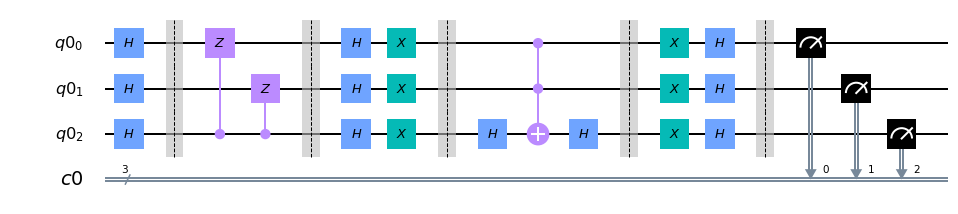

In [8]:
# draw the circuit
groverCircuit.draw(output="mpl")

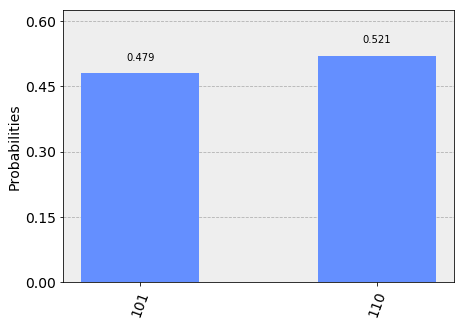

In [9]:
# run with simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [17]:
#IBMQ.update_accounts()
#print(str(IBMQ.stored_account())) 

AttributeError: 'IBMQProvider' object has no attribute 'update_accounts'

In [12]:
# run with real device (max 5 qubits)
IBMQ.load_account()
prov_now=IBMQ.get_provider(hub='ibm-q')
backend = least_busy(prov_now.backends(filters=lambda x: x.configuration().n_qubits <= 5 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_vigo


In [13]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(groverCircuit, backend=backend, shots=shots)

job_monitor(job, interval = 2)

Job Status: job has successfully run


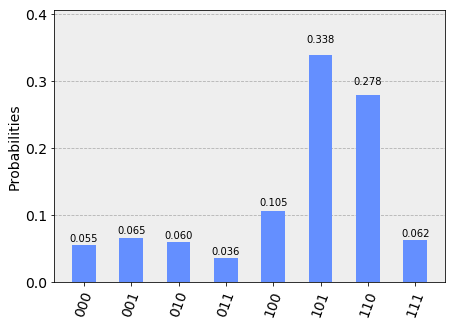

In [14]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)